# Exploratory Spatial Data Analysis of Disaster-Tweets with BERTopic

Run this script in Google Colab or with a GPU instance otherwise this will take quite some time!

## Load dataset and libraries

In [1]:
# Install packages
%%capture
!pip install bertopic

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re

#These liberaries are used for data visualization
import matplotlib.pyplot as plt 
import folium
from folium.plugins import HeatMap

from bertopic import BERTopic
import statistics

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/tweets.csv')
len(df)

30968

# **1. Filter Tweets for timeframe and research area**

In [5]:
max(df.date)

'2021-09-04 23:29:37'

In [6]:
min(df.date)

'2021-06-14 00:06:06'

In [7]:
df = df[df.date<'2021-07-28']
df = df[df.date>'2021-07-06']

In [8]:
min(df.date)

'2021-07-06 00:09:07'

In [9]:
max(df.date)

'2021-07-27 23:59:55'

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkb
tweets_og = df.copy()

# > because of the csv, we need to convert the geom into a shapely format
tweets_og['geometry'] = tweets_og['geom'].apply(lambda x: wkb.loads(x, hex=True))
tweets = gpd.GeoDataFrame(tweets_og, geometry='geometry',crs = "EPSG:4326")
tweets = tweets.drop('geom',axis=1)

# >Iterate through the DataFrame and replace polygons with their centroids => this makes sense due to the results of the next subsection! Polygon size is on average city size
for idx, row in tweets.iterrows():
    if isinstance(row['geometry'], Polygon):
        tweets.at[idx, 'geometry'] = row['geometry'].centroid



### little excursion into the geometries of the tweets (basic statistics)

In [ ]:
import geopandas as gpd

# Reproject the GeoDataFrame to a projected CRS (e.g., EPSG:3035 for Europe)
tweets_projected = tweets.to_crs(epsg=3035)

# Calculate the area in square meters (since EPSG:3035 is in meters)
polygon_sizes = []
for idx, row in tweets_projected.iterrows():
    if isinstance(row['geometry'], Polygon):
        polygon_sizes.append(row['geometry'].area)  # This will now be in square meters

# Convert to square kilometers
polygon_sizes_km2 = tweets_projected.geometry.area / 1e6

Mean: 184.52844460366154
Median: 119.15065236533007
Total Polygons: 9673
Unique Polygons: 1240
Duplicate Polygons: 8433


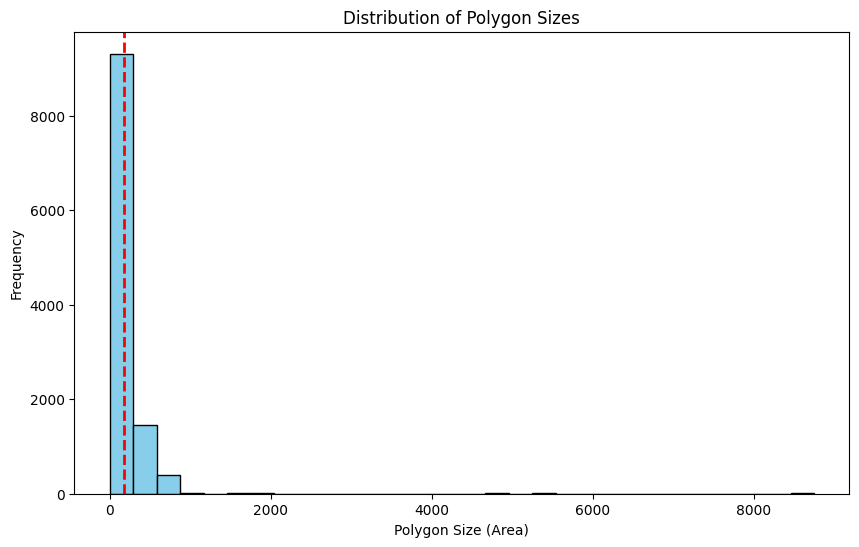

In [ ]:
polygon_sizes = polygon_sizes_km2

# Calculate the mean size of the polygons
import numpy as np
mean_size = np.mean(polygon_sizes)
print('Mean: ' +str(mean_size))
print('Median: ' +str(np.median(polygon_sizes)))

# Print the number of duplicates
# print(f"Total Polygons: {total_polygons}")
# print(f"Unique Polygons: {unique_polygons_count}")
# print(f"Duplicate Polygons: {duplicate_count}")

# Plotting the distribution of polygon sizes
plt.figure(figsize=(10, 6))
plt.hist(polygon_sizes, bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_size, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Polygon Size (Area)')
plt.ylabel('Frequency')
plt.title('Distribution of Polygon Sizes')
plt.show()

## Matching watersheds and tweets

In [ ]:
# load watershed
import geopandas as gpd
import pandas as pd
watersheds = gpd.read_file(r"/content/drive/MyDrive/AoI_WS1_lev12.shp") 
watersheds = watersheds.drop_duplicates('geometry')

In [12]:
# > Joining the point-data with the watershed
joined_gdf = gpd.sjoin(tweets, watersheds.to_crs("EPSG:4326"), how="left", op="within")

#joined_gdf.head()

# > dropping points outside the watershed shapefile
tweets_with_watersheds_filtered = joined_gdf.dropna(subset=['HYBAS_ID'])

In [13]:
df = tweets_with_watersheds_filtered.copy()
len(df)

7232

# **2. Topic Modelling**

In [14]:
df = df.dropna(subset=['text_english'])

In [ ]:
# Preprocess the textual data by removing URLs, mentions, and non-alphabetic characters
df.text = df.apply(lambda row: re.sub(r"http\S+", '', row.text_english).lower(), 1)
df.text = df.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
df.text = df.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
#
timestamps = df[df['text'] != ''].date.to_list()
timestamps = [el[:10] for el in timestamps]
filtered_tweets = df[df['text'] != ''].text.to_list()

In [16]:
len(filtered_tweets)

7223

In [ ]:
# Use stopwords!
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Download stop words for various languages
nltk.download('stopwords')

# Retrieve stop words if needed for different languages
english_stop_words = stopwords.words('english')
# french_stop_words = stopwords.words('french')
# dutch_stop_words = stopwords.words('dutch')
# german_stop_words = stopwords.words('german')

# Concatenate stop words for all languages
all_stop_words = english_stop_words #+ french_stop_words + dutch_stop_words +german_stop_words

# Initialize CountVectorizer with stop words for multiple languages
vectorizer_model = CountVectorizer(stop_words=all_stop_words)#min_df=10, ngram_range=(1, 3)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Run topic modelling
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import time

t1 = time.time()
nr_topics=35 # select number of topics

from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=nr_topics)
# try AgglomerativeClustering
# cluster_model = AgglomerativeClustering(n_clusters=30)

multilingual_model = SentenceTransformer('multi-qa-distilbert-cos-v1')# Try differnet models: multi-qa-distilbert-cos-v1#multi-qa-distilbert-cos-v1#paraphrase-multilingual-mpnet-base-v2# all-mpnet-base-v2 not multilingual
topic_model = BERTopic(language="multilingual", nr_topics=nr_topics, embedding_model=multilingual_model, vectorizer_model=vectorizer_model,
                       verbose = True, hdbscan_model=cluster_model)# hdbscan_model=cluster_model,

topics, probs = topic_model.fit_transform(filtered_tweets)
topic_model.save(r"/content/drive/MyDrive/bertopic_model_'multi-qa-distilbert-cos-v1_30")
#topic_model.visualize_barchart(top_n_topics=50)

t2 = time.time()
print(t2-t1)

2024-08-16 08:32:04,005 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/226 [00:00<?, ?it/s]

2024-08-16 08:40:11,244 - BERTopic - Embedding - Completed ✓
2024-08-16 08:40:11,246 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-16 08:41:02,154 - BERTopic - Dimensionality - Completed ✓
2024-08-16 08:41:02,158 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-16 08:41:03,904 - BERTopic - Cluster - Completed ✓
2024-08-16 08:41:03,912 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-08-16 08:41:04,372 - BERTopic - Representation - Completed ✓
2024-08-16 08:41:04,375 - BERTopic - Topic reduction - Reducing number of topics
2024-08-16 08:41:04,382 - BERTopic - Topic reduction - Reduced number of topics from 35 to 35
2024-08-16 08:41:04,675 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the

566.740296125412


# **3. Topic Stability**

Create several random topic modelling runs to compare keywords

In [ ]:
# Select random ints for topic stabiltiy analysis
import random
str([random.randint(0, 1000) for i in range(0, 20)])

'[362, 756, 708, 330, 723, 354, 412, 471, 211, 122, 998, 492, 634, 251, 621, 839, 661, 544, 50, 294]'

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import time
from sklearn.cluster import KMeans
from umap import UMAP

nr_topics=30
nr_its = 20

cluster_model = KMeans(n_clusters=nr_topics)
random_seeds = [365, 782, 60, 284, 896, 479, 401, 894, 142, 412, 153, 623, 625, 230, 846, 351, 652, 494, 586, 465]
for i in range(nr_its):
  print(i)
  # Open the file in append mode
  umap = UMAP(n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            low_memory=False,
            random_state=random_seeds[i])

  multilingual_model = SentenceTransformer('multi-qa-distilbert-cos-v1')#multi-qa-distilbert-cos-v1#multi-qa-distilbert-cos-v1#paraphrase-multilingual-mpnet-base-v2# all-mpnet-base-v2 not multilingual
  topic_model = BERTopic(language="multilingual", nr_topics=nr_topics, embedding_model=multilingual_model, vectorizer_model=vectorizer_model,
                        verbose = False, hdbscan_model=cluster_model, umap_model=umap)#hdbscan_model=cluster_model,

  topics, probs = topic_model.fit_transform(filtered_tweets)

  topic_model.save(r"/content/drive/MyDrive/bertopic_model_'multi-qa-distilbert-cos-v1_30_version"+str(i))
  # This is the most important file which is needed in the next topic stability file
  file_path = f"/content/drive/MyDrive/topic_model_tf-idf_socres_{nr_its}.txt"  

  # Open the file in append mode
  with open(file_path, 'a') as file:
      file.write(f"&ITERATION_SPLITTER& ")
      for topic_num in range(nr_topics):
          words = topic_model.get_topic(topic_num)
          file.write(f"&TOPIC_SPLITTER& Topic {topic_num}\n")
          file.write(", ".join([f"{word} ({round(value, 4)})" for word, value in words]) + '\n\n')


0


2024-08-19 15:53:09,659 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


1


2024-08-19 15:54:00,427 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


2


2024-08-19 15:54:33,919 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


3


2024-08-19 15:55:10,449 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


4


2024-08-19 15:55:41,844 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


5


2024-08-19 15:56:12,608 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


6


2024-08-19 15:56:43,983 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


7


2024-08-19 15:57:15,226 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


8


2024-08-19 15:57:48,516 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


9


2024-08-19 15:58:21,398 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


10


2024-08-19 15:58:52,786 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


11


2024-08-19 15:59:23,413 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


12


2024-08-19 16:00:00,733 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


13


2024-08-19 16:00:34,812 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


14


2024-08-19 16:01:07,712 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


15


2024-08-19 16:01:39,154 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


16


2024-08-19 16:02:11,054 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


17


2024-08-19 16:02:43,844 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


18


2024-08-19 16:03:21,442 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


19


2024-08-19 16:03:54,318 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Test topic modelling
i=13
topic_model = BERTopic.load(r"/content/drive/MyDrive/bertopic_model_'multi-qa-distilbert-cos-v1_30_version"+str(i) )

# 30 topics
timestamps = [el[:10] for el in timestamps]
topics_over_time = topic_model.topics_over_time(filtered_tweets, timestamps)
# small timeframe model
topic_model.visualize_topics_over_time(topics_over_time, topics=topics)
topic_model.save(r"bertopic_model_'multi-qa-distilbert-cos-v1_30_version"+str(i))


2024-08-19 16:12:43,249 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:

file_path = f"/content/drive/MyDrive/topic_model_tf-idf_socres_{nr_its}.txt"  # File path

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read all contents of the file
    file_content = file.read()

# Print the content to check
print(file_content)


&SPLITTER& Topic 0
people (0.0252), flood (0.0231), affected (0.0225), many (0.0218), floods (0.021), disaster (0.0188), victims (0.0157), lost (0.0155), everything (0.0139), go (0.011)

&SPLITTER& Topic 1
direction (0.1511), near (0.1156), towards (0.1102), blocked (0.1008), closed (0.081), travel (0.0778), charleroi (0.0699), bastogne (0.0655), li (0.0654), flooding (0.0572)

&SPLITTER& Topic 2
cologne (1.0408), intensity (0.7918), precipitation (0.7652), area (0.5014), koelle (0.1118),  (0.0),  (0.0),  (0.0),  (0.0),  (0.0)

&SPLITTER& Topic 3
good (0.0444), luck (0.0419), family (0.037), keep (0.0315), fingers (0.0304), everyone (0.0301), safe (0.0289), crossed (0.028), hope (0.0263), everything (0.0263)

&SPLITTER& Topic 4
fire (0.0762), leverkusen (0.0469), explosion (0.0462), brigade (0.045), dog (0.0287), poison (0.0287), bait (0.0267), responder (0.0184), friesenhagen (0.0184), operation (0.0184)

&SPLITTER& Topic 5
water (0.0766), maas (0.0754), high (0.0567), maastricht (0.0

In [ ]:
# Visualize topics over time
timestamps = [el[:10] for el in timestamps]
topics_over_time = topic_model.topics_over_time(filtered_tweets, timestamps)
# small timeframe model
topic_model.visualize_topics_over_time(topics_over_time, topics=topics)


# Add topics to **df**

In [40]:
topic_dict = topic_model.get_topics()

# Create an empty list to store dictionaries
data = []

# Iterate through the dictionary and format the data
for topic, tuples_list in topic_dict.items():
    words_weights_list = [(word, weight) for word, weight in tuples_list]
    data.append({'topics': topic, 'Words_Weights': words_weights_list})

# Convert the list of dictionaries to a DataFrame
topics_df = pd.DataFrame(data)

# Display the DataFram
topics_df.head(10)

,topics,Words_Weights
0,0,"[(br, 0.5896248537123444), (veghel, 0.44460242..."
1,1,"[(neufch, 0.9785406176500379), (teau, 0.967193..."
2,2,"[(cologne, 1.0714224563201695), (intensity, 0...."
3,3,"[(flood, 0.03977032913303269), (rain, 0.034114..."
4,4,"[(direction, 0.2028368393448871), (travel, 0.1..."
5,5,"[(limburg, 0.09636467650616311), (water, 0.043..."
6,6,"[(vaccinated, 0.0604210513097383), (vaccinatio..."
7,7,"[(flood, 0.0260258353819774), (affected, 0.025..."
8,8,"[(pastoral, 0.7499569222779536), (care, 0.5532..."
9,9,"[(ahrweiler, 0.04704173578164684), (help, 0.02..."


In [41]:
#print(df)
len(topics)

7223

In [ ]:
# Add topics to the input tweets dataframe
df_filtered = df[df['text'] != '']
print(len(df_filtered) == len(topics))
df_filtered['topics'] = topics
df_filtered_final = pd.merge(df_filtered, topics_df, on ='topics', how='left')

True


In [ ]:
# > Export to Drive in csv
df_filtered_final.to_csv(r'drive/MyDrive/tweets_with_topics.csv')